In [1]:
from utils import load_display_options, ignore_warnings
load_display_options()
ignore_warnings()
import pandas as pd


In [2]:
chains = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/playing_style_chains_v2.csv")
match_id = "2022F4_Geelong_Sydney"
team = "Geelong"

Get Plot Data

In [3]:
def create_set_shot_indicator(chain_data):
    
    chain_data['Set_Shot'] = chain_data['Event_Type1'].apply(lambda x: ("Mark" in str(x)) or ("Free" in str(x)))
    
    return chain_data

def get_venue_dimensions(chain_data, match_id):
    
    # Get match chain information
    match = chain_data[chain_data['Match_ID'] == match_id]

    return list(set(match['Venue_Width']))[0], list(set(match['Venue_Length']))[0]

def get_match(chain_data, match_id):
    
    return chain_data[chain_data['Match_ID'] == match_id]

def get_team(chain_data, team):
    
    return chain_data[chain_data['Team'] == team]

def get_shots(chain_data):
    
    shots = chain_data[chain_data['Shot_At_Goal'] == True]
    
    return shots

def get_set_shots(chain_data):
    
    shots = chain_data[chain_data['Shot_At_Goal'] == True]
    set_shots = shots[shots['Set_Shot'] == True]
    
    return set_shots

def get_open_shots(chain_data):
    
    shots = chain_data[chain_data['Shot_At_Goal'] == True]
    open_shots = shots[shots['Set_Shot'] == False]
    
    return open_shots

def get_shot_outcome(shots, final_state):
    
    return shots[shots['Final_State'] == final_state]

In [85]:
def get_shot_data_dict(chains):
    
    chains = create_set_shot_indicator(chains)
    match_chains = get_match(chains, match_id=match_id)
    team_chains = get_team(match_chains, team=team)
    set_shots = get_set_shots(team_chains)
    open_shots = get_open_shots(team_chains)
    
    shot_data_dict = {
        'set_goals': get_shot_outcome(set_shots, "goal"),
        'set_behinds': get_shot_outcome(set_shots, "behind"),
        'set_misses':get_shot_outcome(set_shots, "miss"),
        'open_goals': get_shot_outcome(open_shots, "goal"),
        'open_behinds': get_shot_outcome(open_shots, "behind"),
        'open_misses': get_shot_outcome(open_shots, "miss")}
    
    return shot_data_dict

In [4]:
chains = create_set_shot_indicator(chains)
pitch_width, pitch_length = get_venue_dimensions(chains, match_id=match_id)
match_chains = get_match(chains, match_id=match_id)
team_chains = get_team(match_chains, team=team)
team_shots = get_shots(team_chains)
set_shots = get_set_shots(team_chains)
open_shots = get_open_shots(team_chains)

set_goals = get_shot_outcome(set_shots, "goal")
set_behinds = get_shot_outcome(set_shots, "behind")
set_misses = get_shot_outcome(set_shots, "miss")
open_goals = get_shot_outcome(open_shots, "goal")
open_behinds = get_shot_outcome(open_shots, "behind")
open_misses = get_shot_outcome(open_shots, "miss")

shot_data_dict = {'set_goals': set_goals,
                  'set_behinds': set_behinds,
                  'set_misses':set_misses,
                  'open_goals': open_goals,
                  'open_behinds': open_behinds,
                  'open_misses': open_misses}

Make Plot

In [5]:
from visualisation.visualise import load_fonts, load_mpl_style
visualisation_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/src/visualisation"
font_path = visualisation_path + "/fonts"
style_path = visualisation_path + "/mplstyle/dark_theme.mplstyle"

load_fonts(font_path)
load_mpl_style(style_path)

In [10]:
from mplfooty.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
from visualisation.afl_colours import team_colourmaps, team_colours
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [7]:
def plot_half_vertical_pitch(ax, line_colour="black", line_width = 1, pad_bottom = -20):
    
    pitch = VerticalPitch(pitch_length=160, pitch_width=135,
                          line_colour=line_colour, line_width=line_width,
                          half=True, pad_bottom=pad_bottom)
    pitch.draw(ax=ax)
    
    return pitch, ax

In [81]:
def plot_expected_score_map(pitch, ax, shot_data_dict, cmap, size_ratio = 3):

    norm = plt.Normalize(vmin=0, vmax=6)
    
    pitch.scatter(shot_data_dict['set_misses']['x'], shot_data_dict['set_misses']['y'], ax=ax, s=(shot_data_dict['set_misses']['xScore']**2)*size_ratio, c=cmap(norm(shot_data_dict['set_misses']['xScore'])), alpha=0.3, marker="s")
    pitch.scatter(shot_data_dict['set_behinds']['x'], shot_data_dict['set_behinds']['y'], ax=ax, s=(shot_data_dict['set_behinds']['xScore']**2)*size_ratio, c=cmap(norm(shot_data_dict['set_behinds']['xScore'])), marker="s")
    pitch.scatter(shot_data_dict['set_goals']['x'], shot_data_dict['set_goals']['y'], ax=ax, s=(shot_data_dict['set_goals']['xScore']**2)*size_ratio, c=cmap(norm(shot_data_dict['set_goals']['xScore'])), ec="white", marker="s")

    pitch.scatter(shot_data_dict['open_misses']['x'], shot_data_dict['open_misses']['y'], ax=ax, s=(shot_data_dict['open_misses']['xScore']**2)*size_ratio, c=cmap(norm(shot_data_dict['open_misses']['xScore'])), alpha=0.3)
    pitch.scatter(shot_data_dict['open_behinds']['x'], shot_data_dict['open_behinds']['y'], ax=ax, s=(shot_data_dict['open_behinds']['xScore']**2)*size_ratio, c=cmap(norm(shot_data_dict['open_behinds']['xScore'])))
    pitch.scatter(shot_data_dict['open_goals']['x'], shot_data_dict['open_goals']['y'], ax=ax, s=(shot_data_dict['open_goals']['xScore']**2)*size_ratio, c=cmap(norm(shot_data_dict['open_goals']['xScore'])), ec="white")
    
    return pitch

In [82]:
def add_vertical_shot_map_legend(fig, ax, cmap, size_ratio = 3):
    
    norm = plt.Normalize(vmin=0, vmax=6)
    
    ## Manual Legend
    legend_ax = fig.add_axes([0.72, 0.4, 0.2, 0.3])
    legend_ax.axis("off")
    plt.xlim([0, 7.1])
    plt.ylim([0, 1.1])
    legend_ax.xaxis.set_tick_params(color="white")
    for size in [1, 2, 3, 4, 5, 6]:
        legend_ax.scatter(size, 0.95, s=(size**2)*size_ratio, c=cmap(norm(size)))
    for size in [1, 6]:
        legend_ax.text(size-0.14, 0.82, str(size), color="white", fontsize=8, font='Karla')
        
    legend_ax.scatter(3.5, 0.65, s=(4**2)*size_ratio, c=cmap(norm(4)), ec="white")
    legend_ax.scatter(3.5, 0.53, s=(4**2)*size_ratio, c=cmap(norm(4)))
    legend_ax.scatter(3.5, 0.41, s=(4**2)*size_ratio, c=cmap(norm(4)), alpha=0.3)
    legend_ax.scatter(5, 0.65, s=(4**2)*size_ratio, c=cmap(norm(4)), ec="white", marker="s")
    legend_ax.scatter(5, 0.53, s=(4**2)*size_ratio, c=cmap(norm(4)), marker = "s")
    legend_ax.scatter(5, 0.41, s=(4**2)*size_ratio, c=cmap(norm(4)), alpha=0.3, marker = "s")

    legend_ax.text(2.8, 0.73, "Open", color="white", fontsize=8, font='Karla')
    legend_ax.text(4.5, 0.73, "Set", color="white", fontsize=8, font='Karla')
    legend_ax.text(1, 0.62, "Goal", color="white", fontsize=8, font='Karla')
    legend_ax.text(1, 0.5, "Behind", color="white", fontsize=8, font='Karla')
    legend_ax.text(1, 0.38, "Miss", color="white", fontsize=8, font='Karla')
    
    return ax

<Axes: >

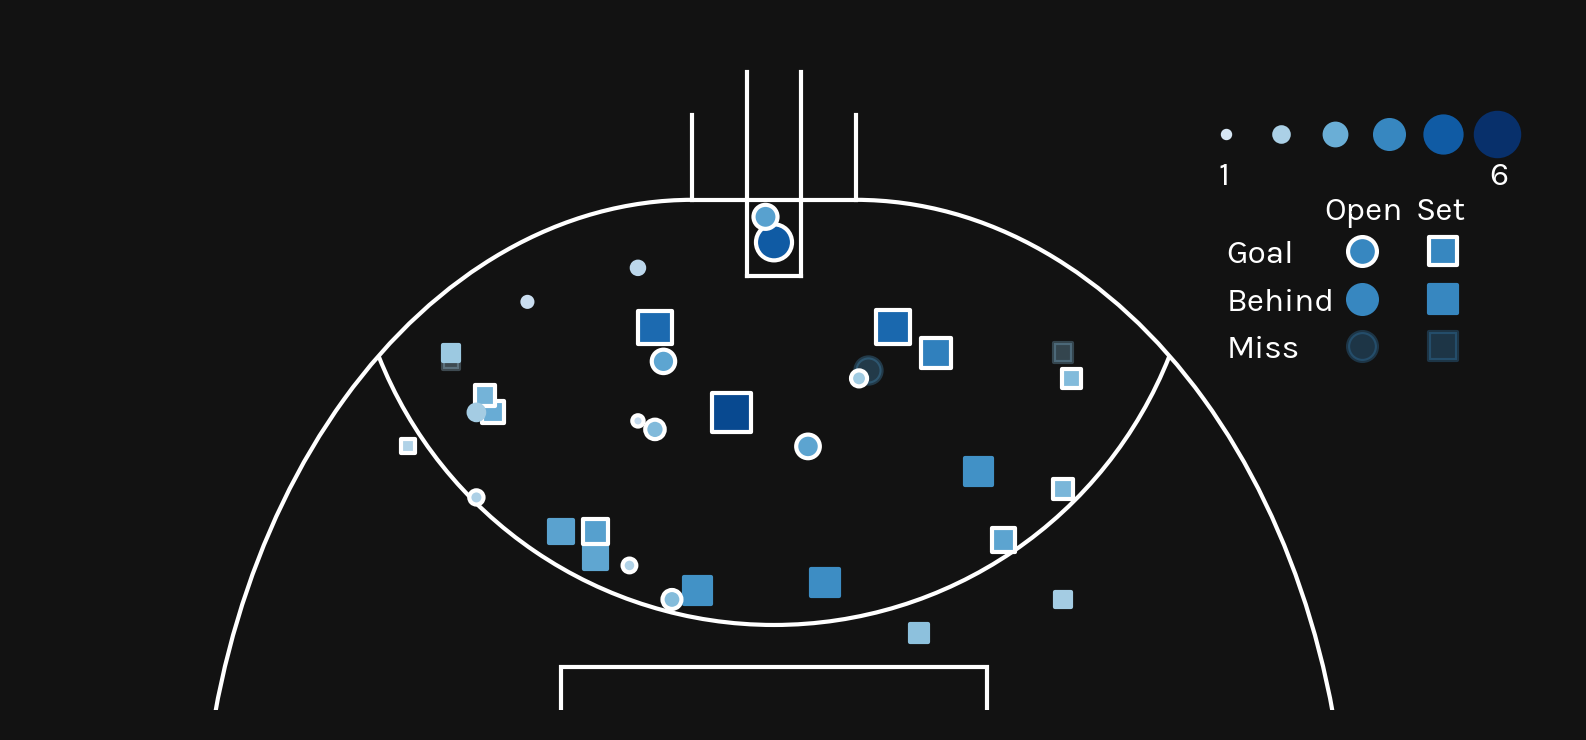

In [84]:
fig, ax = plt.subplots()
pitch, ax = plot_half_vertical_pitch(ax, line_colour="white")
plot_expected_score_map(pitch, ax, shot_data_dict, cmap = team_colourmaps[team])
add_vertical_shot_map_legend(fig, ax, cmap = team_colourmaps[team])

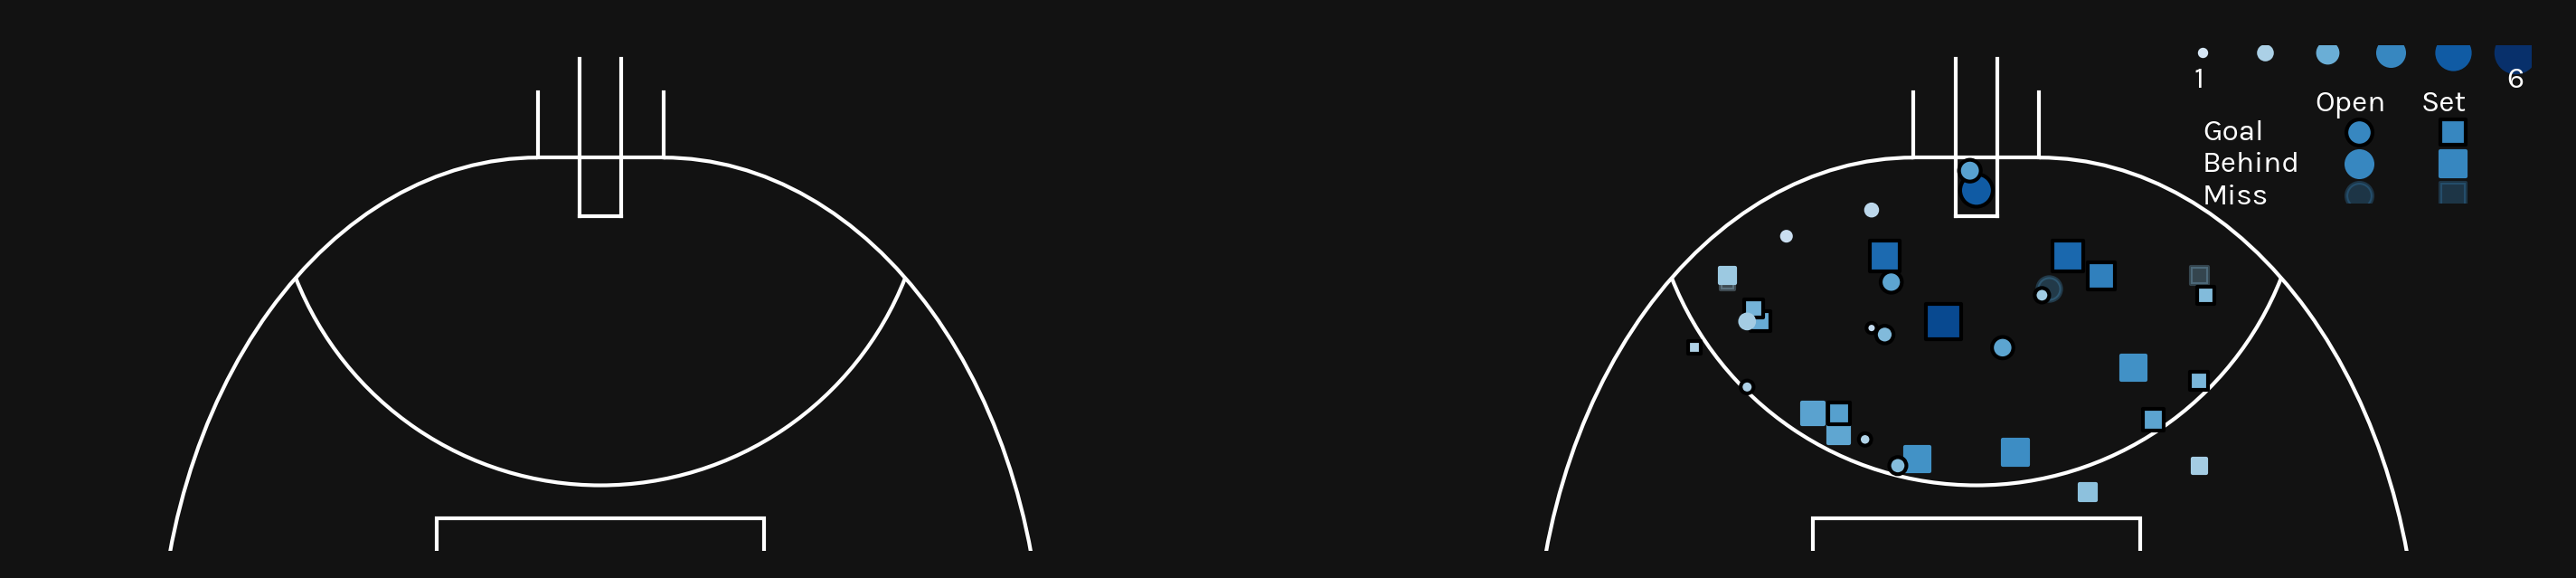

In [38]:
fig, axs = plt.subplots(ncols=2)
fig.set_figheight(12)
fig.set_figwidth(12)
fig.dpi = 300
pitch, axs[1] = plot_half_vertical_pitch(axs[1], line_colour="white")
plot_expected_score_map(pitch, axs[1], shot_data_dict)
add_vertical_shot_map_legend(axs[1])
pitch, axs[0] = plot_half_vertical_pitch(axs[0], line_colour="white")


In [ ]:
def plot_team_expected_score_map(ax, chains, match_id, team):
    
    
    return ax